In [13]:

import sys
import os
import random
import glob
import torch
import pandas as pd
sys.path.append("C:/Users/yuuta/Documents/fashion")
from utils.util import filter_basic_items, open_json
from utils.util import is_target_category
from utils.util import calculate_euclid_sum
# from utils.infer import id_to_vector
from utils.util import calc_roc_auc
import json
import tomotopy as tp

In [14]:
import importlib
import utils
importlib.reload(utils.util)

<module 'utils.util' from 'C:\\Users/yuuta/Documents/fashion\\utils\\util.py'>

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # GPUデバイスを取得
else:
    device = torch.device("cpu")  # CPUデバイスを取得

In [16]:
negative_path = glob.glob(
    "C:/Users/yuuta/Documents/fashion/model_learning/compatibility/data/negative_coordinates/**.json"
)
positive_path = glob.glob(
    "C:/Users/yuuta/Documents/fashion/data/test/**/*.json"
)
negative_path = random.sample(negative_path, 10000)
positive_path = random.sample(positive_path, 20000)

In [17]:
print(len(negative_path), len(positive_path))

10000 20000


In [18]:
id_to_vector = open_json('C:/Users/yuuta/Documents/fashion/model_learning/compatibility/data/id_to_vector.json')

In [19]:
with open(
    "C:/Users/yuuta/Documents/fashion/data/attributes_test.json",
    encoding="shift-jis"
) as f:
    to_attributes = json.load(f)

with open(
    "C:/Users/yuuta/Documents/fashion/data/attributes_train.json",
    encoding="shift-jis"
) as f:
    to_attributes_2 = json.load(f)

to_attributes = {**to_attributes, **to_attributes_2}

In [20]:
lda = tp.LDAModel.load(
    "C:/Users/yuuta/Documents/fashion/model_learning/topic_model/models/lda.bin"
)
ctm = tp.CTModel.load(
    "C:/Users/yuuta/Documents/fashion/model_learning/topic_model/models/ctm.bin"
)
# mdl = tp.MGLDAModel.load(
#     "C:/Users/yuuta/Documents/fashion/model_learning/topic_model/models/MGLDA.bin"
# )

In [21]:
labels = []
proposal_score = []
lda_score = []
ctm_score = []

In [22]:
from utils.infer import topic_model_infer
from utils.util import calculate_euclid_max
p_cnt = 0
for fp in positive_path:
    if p_cnt > 10000:
        break
    json_dict = open_json(fp)
    items = filter_basic_items(json_dict["items"])
    vectors = []
    attributes = []
    for item in items:
        itemId = str(item["itemId"])
        vector = id_to_vector[itemId]
        vectors.append(torch.tensor(vector))

        attr = to_attributes[itemId]
        attributes += attr
    if len(vectors) != 3:
        continue
    ps = 1 / calculate_euclid_max(vectors)
    proposal_score.append(ps.to("cpu"))
    ls = topic_model_infer(lda, attributes)
    cs = topic_model_infer(ctm, attributes)
    lda_score.append(ls)
    ctm_score.append(cs)
    p_cnt += 1
    labels.append(0)


c:\Users\yuuta\anaconda3\envs\fashion\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\yuuta\anaconda3\envs\fashion\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yuuta\anaconda3\envs\fashion\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
n_cnt = 0
for fp in negative_path:
    json_dict = open_json(fp)
    items = filter_basic_items(json_dict["items"])
    vectors = []
    attributes = []
    for item in items:
        itemId = str(item["itemId"])
        vector = id_to_vector[itemId]
        vectors.append(torch.tensor(vector))

        attr = to_attributes[itemId]
        attributes += attr
    if len(vectors) != 3:
        continue
    ps = 1 / calculate_euclid_max(vectors)
    proposal_score.append(ps.to("cpu"))
    ls = topic_model_infer(lda, attributes)
    cs = topic_model_infer(ctm, attributes)
    lda_score.append(ls)
    ctm_score.append(cs)
    labels.append(1)

In [25]:
labels = [1 if i == 0 else 0 for i in labels]

0.6257779201551971 0.5025603583826832 0.4976513477639371


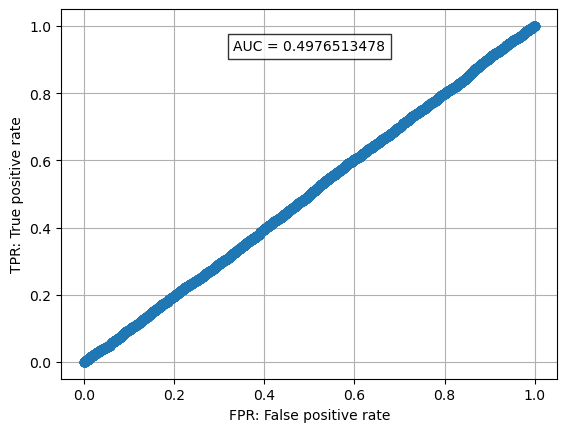

In [26]:
pro_auc = calc_roc_auc(labels, proposal_score, "proposal_model_randomly_coordinates")
lda_auc = calc_roc_auc(labels, lda_score, "lda_model_randomly_coordinates")
ctm_auc = calc_roc_auc(labels, ctm_score, "ct_model_randomly_coordinates")
print(pro_auc, lda_auc, ctm_auc)